In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import nir
import numpy as np

# for loading dataset
import torch

import spyx

In [2]:
ng = nir.read("braille_noDelay_noBias_subtract_subgraph.nir")

In [3]:
data = torch.load("ds_test.pt")

In [4]:
x, y = data.tensors

In [5]:
x = jnp.array(x)

In [6]:
y = jnp.array(y)

In [7]:
x.shape # --> 256 time

(140, 256, 12)

In [8]:
ng.nodes.keys()

dict_keys(['fc1', 'fc2', 'input', 'lif1', 'lif2', 'output'])

In [9]:
ng.edges

[('input', 'fc1'),
 ('fc1', 'lif1'),
 ('lif1', 'fc2'),
 ('fc2', 'lif2'),
 ('lif2', 'output')]

In [10]:
n_list = ["input", "fc1", "lif1", "output"]
subgraph_nodes = {k : ng.nodes[k] for k in n_list}
subgraph_edges = [
    ('input', 'fc1'),
    ('fc1', 'lif1'),
    ('lif1', 'output')
]
subgraph = nir.NIRGraph(subgraph_nodes, subgraph_edges)

In [11]:
subgraph.nodes["output"].output_type['output'] = np.array([40])

In [12]:
SNN, params = spyx.nir.from_nir(subgraph, x, dt=1e-4, return_all_states=True)

found subgraph, trying to parse as RNN
found subgraph, trying to parse as RNN


In [13]:
params.keys()

dict_keys(['linear', 'RCuBaLIF'])

In [14]:
a, b = SNN.apply(params, x)

found subgraph, trying to parse as RNN


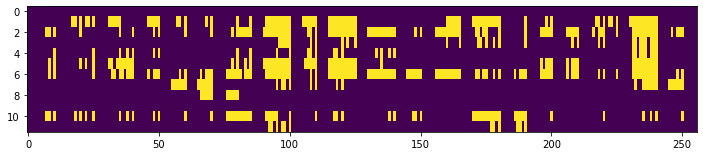

In [15]:
plt.figure(figsize=(12,4))
plt.imshow(x[0].T, aspect=4, interpolation="none")
plt.show()

In [16]:
a.shape

(140, 256, 40)

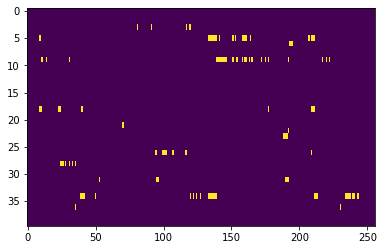

In [17]:
plt.figure(figsize=(12,4))
plt.imshow(a[0].T, aspect=4, interpolation="none")
plt.show()

In [18]:
np.save("spyx_activity_noDelay_noBias_subtract.npy", a[0])

# zero partial network

In [19]:
ng = nir.read("braille_noDelay_bias_zero_subgraph.nir")

In [20]:
n_list = ["input", "fc1", "lif1", "output"]
subgraph_nodes = {k : ng.nodes[k] for k in n_list}
subgraph_edges = [
    ('input', 'fc1'),
    ('fc1', 'lif1'),
    ('lif1', 'output')
]
subgraph = nir.NIRGraph(subgraph_nodes, subgraph_edges)

In [21]:
subgraph.nodes["output"].output_type['output'] = np.array([40])

In [22]:
SNN, params = spyx.nir.from_nir(subgraph, x, dt=1e-4, return_all_states=True)

found subgraph, trying to parse as RNN
found subgraph, trying to parse as RNN


In [23]:
params.keys()

dict_keys(['linear', 'RCuBaLIF'])

In [24]:
a, b = SNN.apply(params, x)

found subgraph, trying to parse as RNN


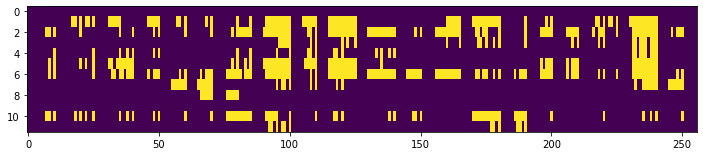

In [25]:
plt.figure(figsize=(12,4))
plt.imshow(x[0].T, aspect=4, interpolation="none")
plt.show()

In [26]:
a.shape

(140, 256, 38)

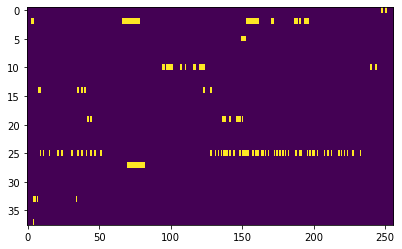

In [27]:
plt.figure(figsize=(12,4))
plt.imshow(a[0].T, aspect=4, interpolation="none")
plt.show()

In [28]:
np.save("spyx_activity_noDelay_bias_zero.npy", a[0])

# Full networks

## subtract

In [29]:
ng = nir.read("braille_noDelay_noBias_subtract_subgraph.nir")

In [30]:
SNN, params = spyx.nir.from_nir(ng, x, dt=1e-4, return_all_states=True)

found subgraph, trying to parse as RNN
found subgraph, trying to parse as RNN


In [31]:
spyx_rec = params["RCuBaLIF"]["w"].T.flatten()
spyx_inp = params["linear"]["w"].T.flatten()

In [32]:
from snntorch import import_nirtorch

nirgraph = nir.read("braille_noDelay_noBias_subtract_subgraph.nir")
net_snn = import_nirtorch.from_nir(nirgraph)

snn_rec = net_snn.lif1.recurrent.weight.detach().reshape(-1)
print('w_rec close?', jnp.allclose(spyx_rec, snn_rec.numpy()))
snn_inp = net_snn.fc1.weight.detach().reshape(-1)
print('fc1 close?', jnp.allclose(spyx_inp, snn_inp.numpy()))

replace rnn subgraph with nirgraph
w_rec close? True
fc1 close? True


In [33]:
a, b = SNN.apply(params, x)

found subgraph, trying to parse as RNN


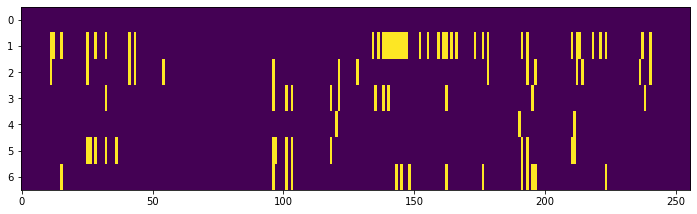

In [34]:
plt.figure(figsize=(12,4))
plt.imshow(a[0].T, aspect=10, interpolation="none")

In [35]:
y

Array([1, 3, 2, 2, 6, 1, 1, 3, 4, 5, 4, 0, 5, 5, 0, 2, 4, 3, 1, 2, 5, 2,
       4, 6, 2, 2, 4, 1, 4, 4, 1, 3, 2, 0, 4, 5, 1, 0, 3, 5, 1, 2, 0, 4,
       5, 4, 5, 6, 6, 1, 4, 5, 0, 2, 3, 4, 5, 0, 2, 5, 5, 5, 6, 5, 6, 4,
       1, 2, 6, 1, 0, 0, 6, 4, 0, 3, 3, 0, 1, 6, 2, 0, 3, 1, 0, 1, 2, 0,
       3, 0, 0, 0, 4, 6, 1, 3, 2, 5, 2, 6, 0, 5, 5, 0, 3, 1, 6, 6, 3, 2,
       4, 4, 6, 3, 6, 2, 2, 5, 3, 6, 2, 1, 3, 6, 5, 4, 5, 4, 1, 6, 3, 0,
       3, 6, 3, 1, 6, 4, 3, 1], dtype=int32)

In [36]:
acc, preds = spyx.fn.integral_accuracy(a, y)
acc

Array(0.92142856, dtype=float32)

In [37]:
np.save("spyx_accuracy_noDelay_noBias_subtract.npy", acc)

# Bias + Zero reset

In [38]:
ng = nir.read("braille_noDelay_bias_zero_subgraph.nir")

In [39]:
SNN, params = spyx.nir.from_nir(ng, x, dt=1e-4, return_all_states=True)

found subgraph, trying to parse as RNN
found subgraph, trying to parse as RNN


In [40]:
spyx_rec = params["RCuBaLIF"]["w"].T.flatten()
spyx_inp = params["linear"]["w"].T.flatten()

In [41]:
from snntorch import import_nirtorch

nirgraph = nir.read("braille_noDelay_bias_zero_subgraph.nir")
net_snn = import_nirtorch.from_nir(nirgraph)

snn_rec = net_snn.lif1.recurrent.weight.detach().reshape(-1)
print('w_rec close?', jnp.allclose(spyx_rec, snn_rec.numpy()))
snn_inp = net_snn.fc1.weight.detach().reshape(-1)
print('fc1 close?', jnp.allclose(spyx_inp, snn_inp.numpy()))

replace rnn subgraph with nirgraph
w_rec close? True
fc1 close? True


In [42]:
a, b = SNN.apply(params, x)

found subgraph, trying to parse as RNN


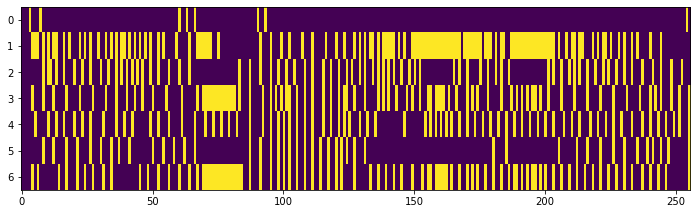

In [43]:
plt.figure(figsize=(12,4))
plt.imshow(a[0].T, aspect=10, interpolation="none")

In [44]:
y

Array([1, 3, 2, 2, 6, 1, 1, 3, 4, 5, 4, 0, 5, 5, 0, 2, 4, 3, 1, 2, 5, 2,
       4, 6, 2, 2, 4, 1, 4, 4, 1, 3, 2, 0, 4, 5, 1, 0, 3, 5, 1, 2, 0, 4,
       5, 4, 5, 6, 6, 1, 4, 5, 0, 2, 3, 4, 5, 0, 2, 5, 5, 5, 6, 5, 6, 4,
       1, 2, 6, 1, 0, 0, 6, 4, 0, 3, 3, 0, 1, 6, 2, 0, 3, 1, 0, 1, 2, 0,
       3, 0, 0, 0, 4, 6, 1, 3, 2, 5, 2, 6, 0, 5, 5, 0, 3, 1, 6, 6, 3, 2,
       4, 4, 6, 3, 6, 2, 2, 5, 3, 6, 2, 1, 3, 6, 5, 4, 5, 4, 1, 6, 3, 0,
       3, 6, 3, 1, 6, 4, 3, 1], dtype=int32)

In [45]:
acc, preds = spyx.fn.integral_accuracy(a, y)
acc

Array(0.8428571, dtype=float32)

In [46]:
np.save("spyx_accuracy_noDelay_bias_zero.npy", acc)